![alt text](https://unisal.br/pos/assets/img/logo.png)
### Pós Graduação em Big Data e Ciência dos Dados 2019

Professor Márcio Brandstatter<br>
Trabalho Final - Projeto de Big Data e Ciência de Dados

* Adilson Pavan - RA 180008379
* Fernando Gozetto - RA 180009447
* Reginaldo Cesar Vanin de Lima - RA 1800094481


# Arquitetura do projeto

![alt text](https://raw.githubusercontent.com/pavanad/covid-impacts/master/architecture.png)

# Impactos do Coronavirus (Covid-19) no Brasil

Apresentar uma breve análise dos indices econômicos e os impactos na econômia brasileira face a pandemia do Covid-19. Para isso, utilizamos o cenário atual do Brasil e comparamos com os principais indicadores socio econômicos.


## Importação das bibliotecas utilizadas nas análises

In [ ]:
import io
import json
import os

import requests

import folium
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
import seaborn as sns
from folium import plugins
from functools import reduce
from matplotlib import pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

import sqlalchemy
!pip install mysql-connector

pd.set_option('display.max_colwidth', 1)
pd.set_option('display.max_rows', 500)
pd.set_option('display.float_format', '{:.2f}'.format)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


     |████████████████████████████████| 11.9MB 342kB/s 
  Created wheel for mysql-connector: filename=mysql_connector-2.2.9-cp36-cp36m-linux_x86_64.whl size=247949 sha256=be0ac31bc46d5e7bd2d1e9a183c08909fba83afff656a2d0d737ab95e1f12c9e
  Stored in directory: /root/.cache/pip/wheels/8c/83/a1/f8b6d4bb1bd6208bbde1608bbfa7557504bed9eaf2ecf8c175
Successfully built mysql-connector


## Funções para coleta, tratamento e apresentação dos dados

In [ ]:
def get_data(url):
    df = pd.DataFrame()
    if requests.get(url).status_code == 200:
        header = {
            "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
            "X-Requested-With": "XMLHttpRequest",
        }
        response = requests.get(url, headers=header)
        data = response.json()
        if isinstance(data, list):
            df = pd.json_normalize(data)
            df["data"] = pd.to_datetime(df["data"], format="%d/%m/%Y", errors="coerce")
            df["valor"] = (
                df["valor"].apply(pd.to_numeric, errors="coerce").astype("float64")
            )
            df = df[
                (df["data"].between("01/01/2019", "31/12/2020", inclusive=True)) == True
            ]
            return df

        content = data
        if "results" in data:
            content = data.get("results")
        elif "value" in data:
            content = data.get("value")
        df = pd.json_normalize(content)

    return df

def merge_datasets(datasets, parameter):
    df = reduce(
        lambda left, right: pd.merge(left, right, on=[parameter], how="left"), datasets
    )
    return df

def map_state(df):
    states_geo = {
        "AC": [-8.77, -70.55],
        "AL": [-9.71, -35.73],
        "AM": [-3.07, -61.66],
        "AP": [1.41, -51.77],
        "BA": [-12.96, -38.51],
        "CE": [-3.71, -38.54],
        "DF": [-15.83, -47.86],
        "ES": [-19.19, -40.34],
        "GO": [-16.64, -49.31],
        "MA": [-2.55, -44.30],
        "MT": [-12.64, -55.42],
        "MS": [-20.51, -54.54],
        "MG": [-18.10, -44.38],
        "PA": [-5.53, -52.29],
        "PB": [-7.06, -35.55],
        "PR": [-24.89, -51.55],
        "PE": [-8.28, -35.07],
        "PI": [-8.28, -43.68],
        "RJ": [-22.84, -43.15],
        "RN": [-5.22, -36.52],
        "RO": [-11.22, -62.80],
        "RS": [-30.01, -51.22],
        "RR": [1.89, -61.22],
        "SC": [-27.33, -49.44],
        "SE": [-10.90, -37.07],
        "SP": [-23.55, -46.64],
        "TO": [-10.25, -48.25],
    }
    df[["latitude", "longitude"]] = [states_geo[i] for i in df["state"]]
    return df


Função para salvar os datasets no banco de dados

In [ ]:
def save_to_database(dataset, table_name):
    database_username = "root"
    database_password = "s4M4x0XrG!^fiz2jQ4cpzx"
    database_ip = "34.67.231.135"
    database_name = "covid"
    database_connection = sqlalchemy.create_engine(
        "mysql+mysqlconnector://{0}:{1}@{2}/{3}".format(
            database_username, database_password, database_ip, database_name
        )
    )
    dataset.to_sql(con=database_connection, name=table_name, if_exists='replace')
    database_connection.dispose()

Função para coleta dos dados do covid

In [ ]:
def get_data_covid():
    urls_covid = {
        "covid": "https://brasil.io/dataset/covid19/caso?format=csv",
        "ibge": "https://raw.githubusercontent.com/sandeco/CanalSandeco/master/covid-19/cidades_brasil.csv",
        "recovered": "https://raw.githubusercontent.com/wcota/covid19br/master/cases-brazil-total.csv",
        "geojson": "https://raw.githubusercontent.com/fititnt/gis-dataset-brasil/master/mesorregiao/geojson/mesorregiao.json",
    }
    gbl = globals()
    for i, row in urls_covid.items():
        try:
            if i == "geojson":            
                gbl[i] = json.loads(requests.get(row).text)            
            else:            
                header = {
                    "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) "
                    "AppleWebKit/537.11 (KHTML, like Gecko) "
                    "Chrome/23.0.1271.64 Safari/537.11",
                    "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8",
                    "Accept-Charset": "ISO-8859-1,utf-8;q=0.7,*;q=0.3",
                    "Accept-Encoding": "none",
                    "Accept-Language": "en-US,en;q=0.8",
                    "Connection": "keep-alive",
                }
                response = requests.get(url=row, headers=header)
                content = io.StringIO(response.content.decode("utf-8"))
                gbl[i] = pd.read_csv(content)

                if i == "covid":
                    gbl[i] = gbl[i].rename(columns={"city_ibge_code": "codigo_ibge"})
                    gbl[i]['date'] = pd.to_datetime(gbl[i]['date'], errors='raise')
                    
                response.raise_for_status()                
        except HTTPError as http_err:
            print(f"HTTP error occurred: {http_err}")
        except Exception as err:
            print(f"Other error occurred: {err}")
        else:
            print(f"Success Dataset {i} !")

Função para coleta dos dados economicos

In [ ]:
def get_data_eco():
    urls = {
        "dolar": "https://olinda.bcb.gov.br/olinda/servico/PTAX/versao/v1/odata/CotacaoDolarPeriodo(dataInicial=@dataInicial,dataFinalCotacao=@dataFinalCotacao)?@dataInicial='01-01-2019'&@dataFinalCotacao='{}-{}-{}'&$top=10000&$format=json&$select=cotacaoCompra,cotacaoVenda,dataHoraCotacao".format(
            "29", "06", "2020"
        ),
        "ipcaa": "http://api.bcb.gov.br/dados/serie/bcdata.sgs.1635/dados?formato=json",  # 1635
        "inpca": "http://api.bcb.gov.br/dados/serie/bcdata.sgs.1644/dados?formato=json",
        "inpcg": "http://api.bcb.gov.br/dados/serie/bcdata.sgs.188/dados?formato=json",
        "ipcag": "http://api.bcb.gov.br/dados/serie/bcdata.sgs.433/dados?formato=json",
        "inad": "http://api.bcb.gov.br/dados/serie/bcdata.sgs.21084/dados?formato=json",
        "dsoc": "http://api.bcb.gov.br/dados/serie/bcdata.sgs.24369/dados?formato=json",
        "npd": "http://api.bcb.gov.br/dados/serie/bcdata.sgs.24380/dados?formato=json",
        "npo": "http://api.bcb.gov.br/dados/serie/bcdata.sgs.24379/dados?formato=json",
    }
    gbl = globals()
    for i, row in urls.items():
        try:

            gbl[i] = get_data(row)
            if i == "dolar":
                gbl[i] = gbl[i][
                    gbl[i]["dataHoraCotacao"].between("2019-01-01", "2020-12-31")
                ]
                gbl[i]["dataHoraCotacao"] = pd.to_datetime(
                    gbl[i]["dataHoraCotacao"], errors="raise"
                )
            else:
                gbl[i].set_axis(["data", f"valor_{i}".lower()], axis=1, inplace=True)
                gbl[i]["year"] = pd.DatetimeIndex(gbl[i]["data"]).year
                gbl[i]["month"] = pd.DatetimeIndex(gbl[i]["data"]).month
        except Exception as err:
            print(f"Other error occurred: {err}")
        else:
            print(f"Success Dataset {i} !")
    
def change_dollar(df):
    df["data"] = (df["dataHoraCotacao"] - pd.offsets.MonthBegin(1)).dt.floor("d")
    df = df.groupby("data")[["cotacaoCompra"]].mean().reset_index()
    df.set_axis(["data", "valor_dolar".lower()], axis=1, inplace=True)
    df["year"] = pd.DatetimeIndex(df["data"]).year
    df["month"] = pd.DatetimeIndex(df["data"]).month
    return df


Funções para apresentação dos dados

In [ ]:
def indicators(xs, ys, rotation, align, font):
    config = {"size": font, "rotation": rotation, "textcoords": "offset pixels"}
    for x, y in zip(xs, ys):
        label = "{:.1f}".format(y)        
        if align == "h":
            coords = (y, x)
            config.update({"va": "center", "xytext": (5, 0)})
        elif align == "v":
            coords = (x, y)
            config.update({"ha": "center", "xytext": (0, 5)})
        plt.annotate(label, coords, **config)


def base_map(tiles, zoom, location):
    base_map = folium.Map(
        width=1280, height=720, location=location, zoom_start=zoom, tiles=tiles
    )
    return base_map


def fullscreen(mapa):
    plugins.Fullscreen(
        position="topright",
        title="FullScreen",
        title_cancel="Exit",
        force_separate_button=True,
    ).add_to(mapa)

def plot_two(x, y, x1, y1, label1, label2, title):
  fig = plt.figure(figsize=[21,6])
  plt.plot(x, y, 'bo--', label=label1, markersize=8)
  plt.plot(x1, y1, 'ro--', label=label2, markersize=8)
  plt.legend()
  plt.title(title, size=18)
  indicators(x, y, 0, 'v', 10)
  indicators(x1, y1, 0, 'v', 10)

  fig.tight_layout()
  plt.show()

## Coleta e tratamento dos dados do Covid-19

Dados importados da base do brasil.io em tempo real sobre o Covid-19.

In [ ]:
get_data_covid()

Success Dataset covid !
Success Dataset ibge !
Success Dataset recovered !
Success Dataset geojson !


Unificando dataset do IBGE de geolocalização com o covid

In [ ]:
covid_ibge = merge_datasets(
    [covid, ibge[["codigo_ibge", "latitude", "longitude"]]], "codigo_ibge"
)
states = (
    covid_ibge.loc[
        (covid_ibge.place_type == "state") & (covid_ibge.is_last == True),
        ["state", "confirmed", "deaths", "latitude", "longitude"],
    ]
    .sort_values(by=["state"])
    .set_index("state")
    .reset_index()
)

Unificando dataset de recuperados como o dataset do Covid

In [ ]:
states =  merge_datasets([states, recovered[['state', 'recovered']]], 'state')
states['mortalidade_p'] = states['deaths'] / states['confirmed'] * 100
states['recovered_p'] = states['recovered'] / states['confirmed'] * 100

Mapeando a Geolocalização dos Estados com o dataset do Covid

In [ ]:
states = map_state(states)
states.fillna(0, inplace=True)

Criando o dataset das cidades

In [ ]:
cities = (
    covid_ibge.loc[
        (covid_ibge.place_type == "city") & (covid_ibge.is_last == True),
        ["state", "city", "confirmed", "deaths", "latitude", "longitude"],
    ]
    .sort_values(by=["state"])
    .set_index("state")
    .reset_index()
)
cities = cities.loc[cities.city.isna() == False].dropna()

## Situação atual dos estados com números de casos confirmados, mortes e recuperados

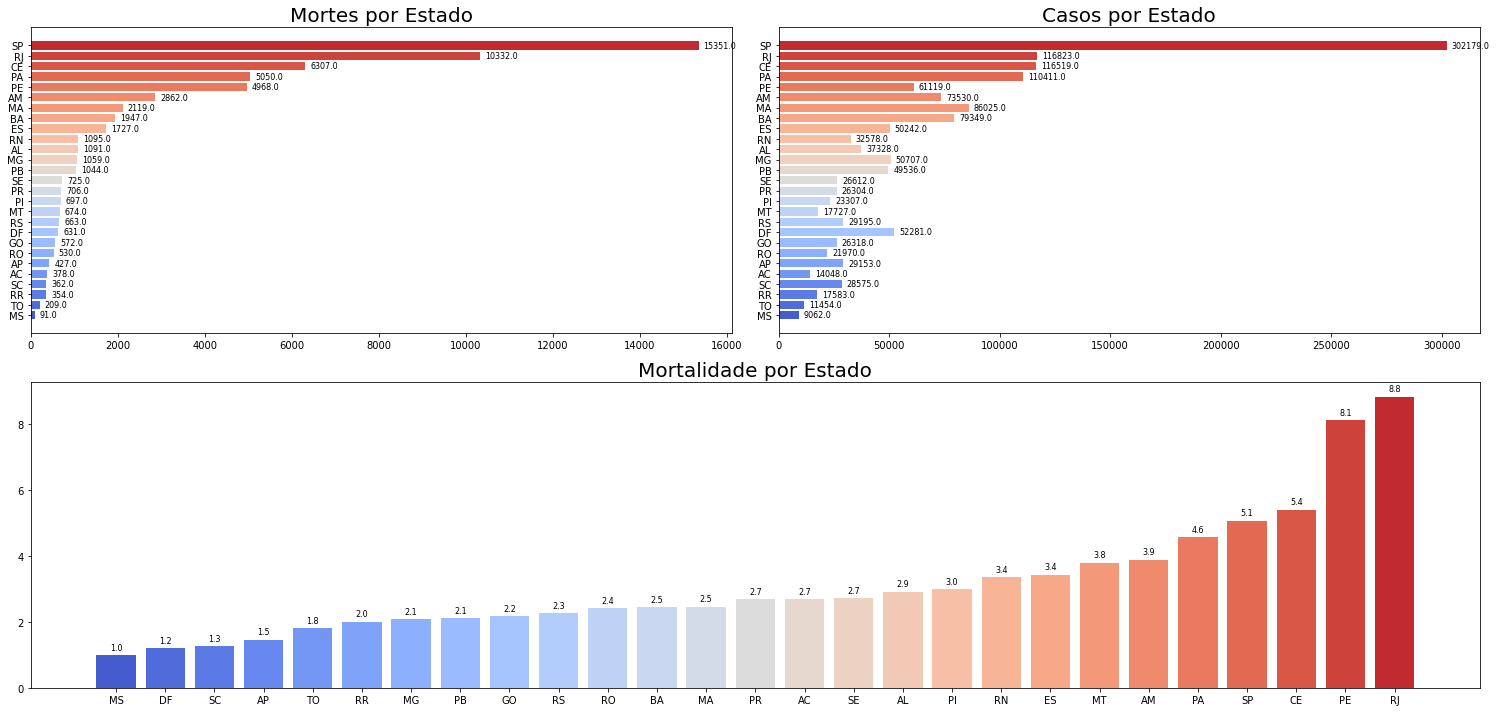

In [ ]:
fig = plt.figure(figsize=[21, 10])
gs = fig.add_gridspec(2, 2)

def plot_barh(x, y, label, col):
    im = fig.add_subplot(gs[0, col])
    im.barh(x, y, color=sns.color_palette("coolwarm", 27))
    im.set_title(label, size = 20)
    indicators(x, y, 0, "h", 8)

x = states[["state", "deaths"]].sort_values(by=["deaths"])["state"]
y = states[["state", "deaths"]].sort_values(by=["deaths"])["deaths"]
w = states[["state", "deaths", "confirmed"]].sort_values(by=["deaths"])["confirmed"]
z = states[["state", "deaths", "mortalidade_p"]].sort_values(by=["deaths"])["mortalidade_p"]

# grafico 1
plot_barh(x, y, "Mortes por Estado", 0)

# grafico 2
plot_barh(x, w, "Casos por Estado", 1)

# grafico 3
im = fig.add_subplot(gs[1, :])
im.bar(
    states[["state", "mortalidade_p"]].sort_values(by=["mortalidade_p"])["state"],
    states[["state", "mortalidade_p"]].sort_values(by=["mortalidade_p"])["mortalidade_p"],
    color=sns.color_palette("coolwarm", 27),
)
im.set_title("Mortalidade por Estado", size = 20)
indicators(
    states[["state", "mortalidade_p"]].sort_values(by=["mortalidade_p"])["state"],
    states[["state", "mortalidade_p"]].sort_values(by=["mortalidade_p"])["mortalidade_p"], 0, "v", 8)

fig.tight_layout()
plt.show()

Cenário geral por estado de casos, mortes vs recuperados

In [ ]:
x = states.sort_values(by="confirmed")["state"]
y = states.sort_values(by="confirmed")["deaths"]
z = states.sort_values(by="confirmed")["recovered"]
w = states.sort_values(by="confirmed")["confirmed"]

fig = plt.figure(figsize=[21, 6])
plt.plot(x, y, "bo--", label="Mortes", linewidth=3, markersize=8)
plt.plot(x, z, "ro--", label="Recuperados", markersize=8)
plt.plot(x, w, "yo-.", label="Casos", markersize=8)
plt.legend()
plt.title("Demonstrativo de Casos, Mortes vs Recuperados", size = 20)
indicators(x, z, 0, "v", 9)
indicators(x, y, 0, "v", 9)
indicators(x, w, 0, "v", 9)

fig.tight_layout()
plt.show()

## Mapa com o cenário atual dos casos confirmados e mortes

In [ ]:
brasil = [-15.788497, -47.879873]
map_obj = base_map("cartodbpositron", 4, brasil)
folium.Choropleth(
    geo_data=geojson,
    name="choropleth",
    data=states,
    columns=["state", "deaths"],
    key_on="feature.properties.UF",
    fill_color="OrRd",
    fill_opacity=0.7,
    line_opacity=0.3,
    legend_name="Casos",
).add_to(map_obj)

# adicionando pontos no mapa com as informações
for index, row in states.iterrows():
    html = f"""
        <table)
            <tr>
                <th><b>{row['state']}</th>
            </tr>
            <tr>
                <td><h6>Mortes: {str("{:.0f}".format(row['deaths']))}</h6></td>
                <td><h6>Casos: {str("{:.0f}".format(row['confirmed']))}</h6></td>
            </tr>
        </table>
        """
    folium.Marker(
        location=[row["latitude"], row["longitude"]],
        popup    = html,
        tooltip=html,
        icon=plugins.BeautifyIcon(
            border_color="#00ABDC",
            text_color="#00ABDC",
            number=row["state"],
            inner_icon_style="margin-top:0;",
        ),
    ).add_to(map_obj)
map_obj

## Regressão polinomial dos casos confirmados e mortes

In [ ]:
df = covid.copy()
df = df.dropna()

### Filtra os casos confirmados e de mortes desde o ínicio

In [ ]:
confirmed = df["confirmed"].groupby(df["date"]).sum().sort_values(ascending=True)
confirmed = confirmed[confirmed > 0].reset_index().drop('date',axis=1)

deaths = df["deaths"].groupby(df["date"]).sum().sort_values(ascending=True)
deaths = deaths[deaths > 0].reset_index().drop('date',axis=1)

### Convertendo os dados para um array (padrão esperado pelo algoritmo de regressão)

In [ ]:
days_since_first_case = np.array([i for i in range(len(confirmed.index))]).reshape(-1, 1)
confirmed_cases = np.array(confirmed).reshape(-1, 1)

days_since_first_death = np.array([i for i in range(len(deaths.index))]).reshape(-1, 1)
deaths_cases = np.array(deaths).reshape(-1, 1)

Como mostra o gráfico abaixo a relação entre número de casos confirmados e dias resulta em uma curva crescente, ou seja, para tentar fazer a predição do número de casos o mais indicado é utilizar um modelo de regressão polinomial com um grau que será calculado.

In [ ]:
plt.figure(figsize=(16, 9))
plt.scatter(days_since_first_case, confirmed_cases)
plt.title("Distribuição dos casos", size = 20)
plt.show()

### Preparando os índices para a predição

In [ ]:
days_in_future = 3
future_forecast = np.array([i for i in range(len(confirmed.index) + days_in_future)]).reshape(-1, 1)
adjusted_dates = future_forecast[:-3]

future_forecast_deaths = np.array([i for i in range(len(deaths.index) + days_in_future)]).reshape(-1, 1)
adjusted_dates_deaths = future_forecast_deaths[:-3]

### Dividindo os dados de treino e teste para o modelo

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(
    days_since_first_case, confirmed_cases, test_size=10, shuffle=False, random_state=42
)

x_train_death, x_test_death, y_train_death, y_test_death = train_test_split(
    days_since_first_death, deaths_cases, test_size=10, shuffle=False, random_state=42
)

### Função para facilitar a criação dos modelos 

In [ ]:
def create_model(x_train, x_test, y_train, future_forecast, degree):

    # transform our cases data for polynomial regression
    poly = PolynomialFeatures(degree=degree)
    poly_x_train = poly.fit_transform(x_train)
    poly_x_test = poly.fit_transform(x_test)
    poly_future_forecast = poly.fit_transform(future_forecast)

    # polynomial regression cases
    linear_model = LinearRegression(normalize=True, fit_intercept=False)
    linear_model.fit(poly_x_train, y_train)
    linear_pred_test = linear_model.predict(poly_x_test)
    linear_pred_train = linear_model.predict(poly_x_train)
    linear_pred = linear_model.predict(poly_future_forecast)

    return linear_pred_test, linear_pred_train, linear_pred

### Função para identificar o melhor grau e calcular o erro quadratico médio para decidir

In [ ]:
def get_best_degree(x_train, y_train, x_test, y_test, future_forcast):
    degree = 0
    rmse = 10000
    rm_list = []
    for i in range(101):
        
        # create model
        linear_pred_test, _, _ = create_model(x_train, x_test, y_train, future_forecast, i)

        # evaluating with RMSE
        rm = sqrt(mean_squared_error(y_test, linear_pred_test))
        rm_list.append(rm)
        
        if min(rm_list) == rm:
            rmse = rm
            degree = i

        if(i==100):
            print('the best mae is:',round(rmse,2))
            print('the best degree for cases is:',degree)

    return degree

### Cria o modelo com o melhor grau calculado

**Modelo dos casos confirmados**

In [ ]:
degree_cases = get_best_degree(x_train, y_train, x_test, y_test, future_forecast)

the best mae is: 15556.35
the best degree for cases is: 12


In [ ]:
linear_pred_test, linear_pred_train, linear_pred = create_model(x_train, x_test, y_train, future_forecast, degree_cases)

**Modelo das mortes confirmadas**

In [ ]:
degree_deaths = get_best_degree(x_train_death, y_train_death, x_test_death, y_test_death, future_forecast_deaths)

the best mae is: 545.57
the best degree for cases is: 5


In [ ]:
linear_pred_test_death, linear_pred_train_death, linear_pred_death = create_model(x_train_death, x_test_death, y_train_death, future_forecast_deaths, degree_deaths)

### Apresenta os gráficos com os resultados para os casos confirmados

In [ ]:
plt.figure(figsize=(16, 9))
plt.scatter(x_train, y_train)
plt.plot(x_train, linear_pred_train, color="red")
plt.title("Comparação do modelo com os dados reais", size = 20)
plt.show()

In [ ]:
plt.figure(figsize=(16, 9))
plt.plot(y_test, label="Casos reais")
plt.plot(linear_pred_test, label="Previsão")
plt.title("Previsão x Casos reais", size=20)
plt.xlabel("Dias", size=15)
plt.ylabel("Casos", size=15)
plt.xticks(size=12)
plt.yticks(size=12)

# defyning legend config
plt.legend(
    loc="upper left",
    frameon=True,
    ncol=2,
    fancybox=True,
    framealpha=0.95,
    shadow=True,
    borderpad=1,
    prop={"size": 15},
)
plt.show()

In [ ]:
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, confirmed_cases, label="Casos reais")
plt.plot(
    future_forecast,
    linear_pred,
    label="Previsões da regressão polinomial",
    linestyle="dashed",
    color="orange",
)

plt.title("Casos ao longo do tempo: Prevendo os próximos 3 dias", size=20)
plt.ylabel("Casos", size=30)
plt.xticks(size=20)
plt.yticks(size=20)

plt.axvline(len(x_train), color="black", linestyle="--", linewidth=1)
plt.text(18, 5000, "modelo de treinamento", size=15, color="black")
plt.text((len(x_train) + 0.2), 15000, "previsão", size=15, color="black")

# defyning legend config
plt.legend(
    loc="upper left",
    frameon=True,
    ncol=2,
    fancybox=True,
    framealpha=0.95,
    shadow=True,
    borderpad=1,
    prop={"size": 15},
)
plt.show()

### Apresenta os gráficos com os resultados para as mortes confirmadas

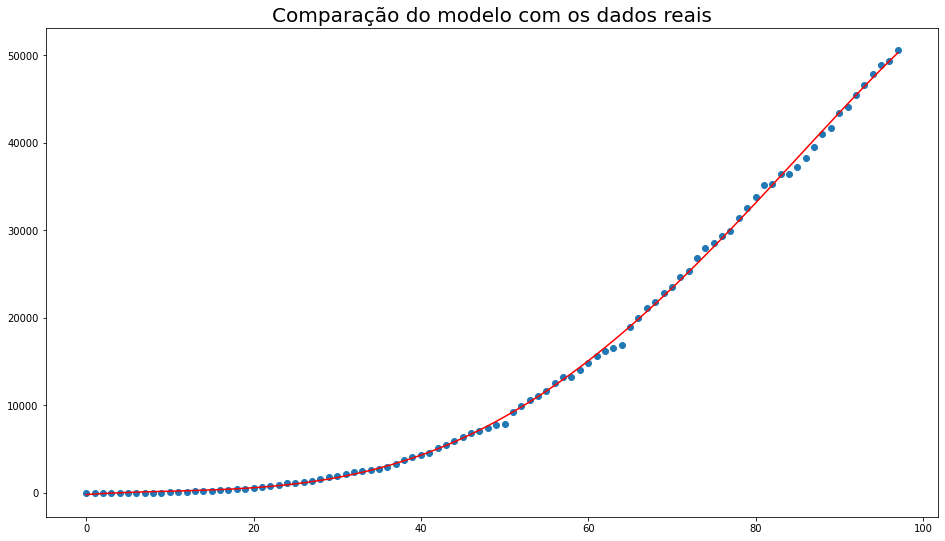

In [ ]:
plt.figure(figsize=(16, 9))
plt.scatter(x_train_death, y_train_death)
plt.plot(x_train_death, linear_pred_train_death, color="red")
plt.title("Comparação do modelo com os dados reais", size = 20)
plt.show()

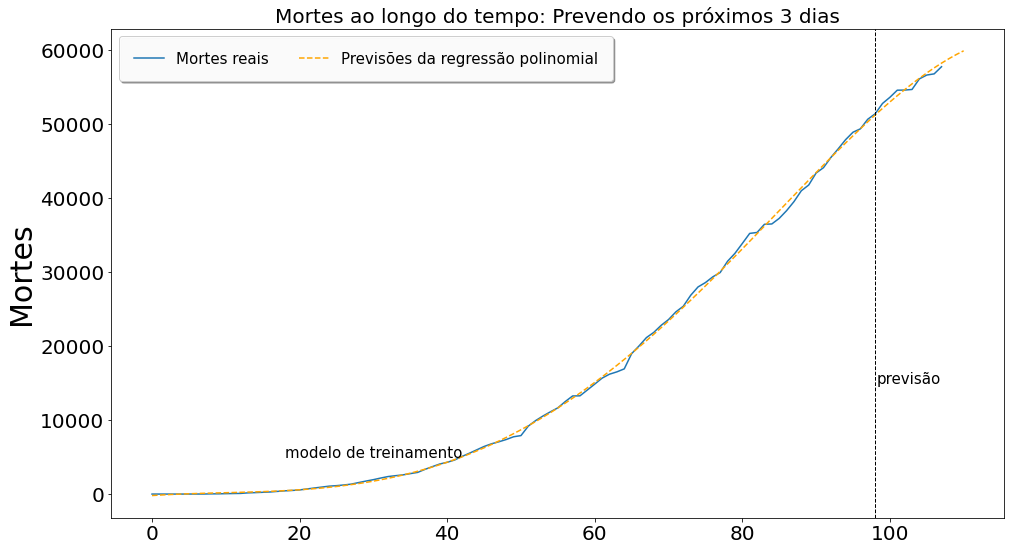

In [ ]:
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates_deaths, deaths_cases, label="Mortes reais")
plt.plot(
    future_forecast_deaths,
    linear_pred_death,
    label="Previsões da regressão polinomial",
    linestyle="dashed",
    color="orange",
)

plt.title("Mortes ao longo do tempo: Prevendo os próximos 3 dias", size=20)
plt.ylabel("Mortes", size=30)
plt.xticks(size=20)
plt.yticks(size=20)

plt.axvline(len(x_train_death), color="black", linestyle="--", linewidth=1)
plt.text(18, 5000, "modelo de treinamento", size=15, color="black")
plt.text((len(x_train_death) + 0.2), 15000, "previsão", size=15, color="black")

# defyning legend config
plt.legend(
    loc="upper left",
    frameon=True,
    ncol=2,
    fancybox=True,
    framealpha=0.95,
    shadow=True,
    borderpad=1,
    prop={"size": 15},
)
plt.show()

# Cenário econômico brasileiro



O objetivo é apresentar os principais indicadores econômicos e entender os impactos causados pela pandemica na economia brasileira.

## Coleta e tratamento dos dados da economia

In [ ]:
get_data_eco()

Other error occurred: 'dataHoraCotacao'
Success Dataset ipcaa !
Success Dataset inpca !
Success Dataset inpcg !
Success Dataset ipcag !
Success Dataset inad !
Success Dataset dsoc !
Success Dataset npd !
Success Dataset npo !


Coletando o dataset do dólar

In [ ]:
dolarm = change_dollar(dolar)
dolarm.head(3)

KeyError: ignored

Unificando os datasets econômicos

In [ ]:
datasets = [dolarm, ipcaa, inpca, ipcag, inpcg, inad, dsoc, npd, npo]
bc_dataset = merge_datasets(datasets, 'data')

## Correlação dos principais indicadores econômicos

In [ ]:
labels = ["DOLAR", "IPCAA", "INPCA", "IPCAG", "INPCG", "INAD", "DSOC", "NPD", "NPO"]
f = plt.figure(figsize=(8, 8))
chart_heatmap = sns.heatmap(
    bc_dataset[
        [
            "data",
            "valor_dolar",
            "valor_ipcaa",
            "valor_inpca",
            "valor_ipcag",
            "valor_inpcg",
            "valor_inad",
            "valor_dsoc",
            "valor_npd",
            "valor_npo",
        ]
    ].corr(),
    xticklabels=labels,
    yticklabels=labels,
    annot=True,
)
chart_heatmap.axes.set_title(
    "Correlação entre os indicadores econômicos", fontsize=14, y=1.01
)
plt.show()

## IPCA - Índice de Preços para o Consumidor Amplo

**O que é o Índice IPCA?**
O IPCA é o Índice de Preços para o Consumidor Amplo. Esse importante índice é medido mensalmente pelo IBGE para identificar a variação dos preços no comércio.
O indicador reflete o custo de vida de famílias com renda mensal de 1 a 40 salários mínimos, qualquer que seja a fonte, residentes nas regiões metropolitanas.

**Ele é considerado, pelo Banco Central, o índice brasileiro oficial da inflação ou deflação.**

**Como o Índice IPCA Funciona e Como Afeta Sua Vida?**
Este indicador é responsável pelo ajuste dos preços em todas as nossas compras (para cima e para baixo) e afetando até mesmo a rentabilidade dos investimentos. É um dos instrumentos utilizados para medir a variação de preços, tanto no passado quanto nos dias de hoje, é o IPCA.
Assim, ele funciona como um termômetro para a economia brasileira, reunindo informações que ajudam o consumidor a entender o que vai encontrar na hora da compra.
Serve como instrumento de correção de determinadas aplicações financeiras, que têm nele o seu índice de referência, é o caso de alguns títulos do Tesouro Direto.

In [ ]:
x, y = [
    ipcaa.loc[ipcaa.year == 2019]["month"],
    ipcaa.loc[ipcaa.year == 2019]["valor_ipcaa"],
]
x1, y1 = [
    ipcaa.loc[ipcaa.year == 2020]["month"],
    ipcaa.loc[ipcaa.year == 2020]["valor_ipcaa"],
]

plot_two(x, y, x1, y1, "2019", "2020", "Evolução do % do IPCA - Setor Alimenticio")

In [ ]:
x, y = [
    ipcag.loc[ipcag.year == 2019]["month"],
    ipcag.loc[ipcag.year == 2019]["valor_ipcag"],
]
x1, y1 = [
    ipcag.loc[ipcag.year == 2020]["month"],
    ipcag.loc[ipcag.year == 2020]["valor_ipcag"],
]

plot_two(x, y, x1, y1, "2019", "2020", "Evolução do % do IPCA - Todos os Setores")

## INPC - Índices de Preços ao Consumidor

**O que é o INPC?** O INPC (Sistema Nacional de Índices de Preços ao Consumidor – SNIPC) produz contínua e sistematicamente o Índice Nacional de Preços ao Consumidor – INPC que tem por objetivo a correção do poder de compra dos salários, através da mensuração das variações de preços da cesta de consumo da população assalariada com mais baixo rendimento. Esta faixa de renda foi criada com o objetivo de garantir uma cobertura populacional de 50% das famílias cuja pessoa de referência é assalariada e pertencente às áreas urbanas de cobertura do SNIPC - Sistema Nacional de Índices de Preços ao Consumidor.

Atualmente, a população-objetivo do INPC abrange as famílias com rendimentos de 1 a 5 salários mínimos, cuja pessoa de referência é assalariada, residentes nas áreas urbanas das regiões de abrangência do SNIPC. Além disso, o índice é constantemente utilizado como referência em ajustes salariais e inflação.

In [ ]:
x, y = [
    inpca.loc[inpca.year == 2019]["month"],
    inpca.loc[inpca.year == 2019]["valor_inpca"],
]
x1, y1 = [
    inpca.loc[inpca.year == 2020]["month"],
    inpca.loc[inpca.year == 2020]["valor_inpca"],
]

plot_two(x, y, x1, y1, "2019", "2020", "Evolução do % do INPC - Setor Alimenticio")

In [ ]:
x, y = [
    inpcg.loc[inpcg.year == 2019]["month"],
    inpcg.loc[inpcg.year == 2019]["valor_inpcg"],
]
x1, y1 = [
    inpcg.loc[inpcg.year == 2020]["month"],
    inpcg.loc[inpcg.year == 2020]["valor_inpcg"],
]

plot_two(x, y, x1, y1, "2019", "2020", "Evolução do % do INPC - Todos os Setores")

## Indicadores de inadimplência e desemprego

Acompanhamento do % percentual de Inadimplencia

In [ ]:
x, y = [inad.loc[inad.year == 2019]["month"], inad.loc[inad.year == 2019]["valor_inad"]]
x1, y1 = [
    inad.loc[inad.year == 2020]["month"],
    inad.loc[inad.year == 2020]["valor_inad"],
]

plot_two(x, y, x1, y1, "2019", "2020", "Evolução do % de Inadimplencia")

Acompanhamento do % percentual de Desocupação

In [ ]:
x, y = [dsoc.loc[dsoc.year == 2019]["month"], dsoc.loc[dsoc.year == 2019]["valor_dsoc"]]
x1, y1 = [
    dsoc.loc[dsoc.year == 2020]["month"],
    dsoc.loc[dsoc.year == 2020]["valor_dsoc"],
]

plot_two(x, y, x1, y1, "2019", "2020", "Evolução do Desemprego a cada MIL")

Número de pessoas Desempregadas (PNAD) - Unidades em mil

In [ ]:
x, y = [npd.loc[npd.year == 2019]["month"], npd.loc[npd.year == 2019]["valor_npd"]]
x1, y1 = [npd.loc[npd.year == 2020]["month"], npd.loc[npd.year == 2020]["valor_npd"]]

plot_two(x, y, x1, y1, "2019", "2020", "Numero de Pessoas desempregadas (cada Mil)")

Número de Pessoas Ocupadas (PANDC) - Unidades em mil

In [ ]:
x, y = [npo.loc[npo.year == 2019]['month'], npo.loc[npo.year == 2019]['valor_npo']]
x1, y1 = [npo.loc[npo.year == 2020]['month'], npo.loc[npo.year == 2020]['valor_npo']]

plot_two(x, y, x1, y1, '2019', '2020', 'Numero de Pessoas Empregadas (cada Mil)')

## Evolução do valor do dólar

Com o gráfico abaixo é possível observar que a distribuição dos valores de cotação ficam 50% entre 3.87 e 4.30, além disso é possível identificar alguns outliers que podem ser explicados com o aumento de casos do covid e as medidas de isolamento.

In [ ]:
bc_dataset["valor_dolar"].describe()

In [ ]:
fig = plt.figure(figsize=[21,6])
plt.boxplot(bc_dataset["valor_dolar"])
plt.title("Distribuição da cotação do dólar", size = 20)
plt.show()

Cotação do Dolar em 2020 fornecedida pelo Banco Central

In [ ]:
x, y = [
    dolarm.loc[dolarm.year == 2019]["month"],
    dolarm.loc[dolarm.year == 2019]["valor_dolar"],
]
x1, y1 = [
    dolarm.loc[dolarm.year == 2020]["month"],
    dolarm.loc[dolarm.year == 2020]["valor_dolar"],
]


plot_two(x, y, x1, y1, "2019", "2020", "Evolução do Valor do Dolar")

### Comparação entre o número de casos confirmados e a cotação do dólar

A comparação mostra que com o avanço da pandemia e com o aumento das medidas de isolamento a cotação do dólar ultrapassou a marca de R$ 5 pela primeira vez na história.

In [ ]:
dolar["date"] = pd.to_datetime(dolar["dataHoraCotacao"].dt.strftime("%Y-%m-%d"))
covid_dolar = pd.merge(
    covid_ibge,
    dolar[["date", "cotacaoCompra"]],
    left_on="date",
    right_on="date",
    how="left",
).fillna(method="pad")
df_cd = (
    covid_dolar.query("place_type == 'state'")
    .groupby(["date", "cotacaoCompra"])[["deaths", "confirmed"]]
    .sum()
    .reset_index()
)

In [ ]:
x, y = df_cd["date"], df_cd["confirmed"]
x1, y1 = df_cd["date"], df_cd["cotacaoCompra"]

fig = plt.figure(figsize=[21, 6])
ax = fig.subplots(2)
ax[0].plot(x, y, "bo--", label="Casos confirmados", markersize=8)
ax[0].set_title("Casos confirmados Covid vs Cotação dólar", size = 20)
ax[1].plot(x1, y1, "ro--", label="Dólar", markersize=8)
plt.legend()
plt.show()

Além do aumento histórico também é possível notar uma queda muito rápida iniciada  na segunda metade de Maio que provavelmente está relacionada ao relaxamento das medidas de isolamento e uma leve retomada da economia.

# Salvando dados no banco de dados

Os datasets utilizados na análise serão armazenados em um banco de dados MySQL criado na infraestrutura do Google para facilitar a criação dos relatórios no Google Data Studio.

In [ ]:
save_to_database(states, "states")
save_to_database(cities, "cities")
save_to_database(bc_dataset, "economic")
save_to_database(df_cd, "covid_dollar")

Consolidando as séries da regressão de casos confirmados

In [ ]:
forecast_confirmed_cases = pd.DataFrame(data=linear_pred, columns=["prediction"])
forecast_aux = pd.DataFrame(data=confirmed_cases, columns=["confirmed_cases"])
forecast_confirmed_cases["confirmed_cases"] = forecast_aux["confirmed_cases"]
forecast_confirmed_cases["days"] = list(range(len(future_forecast)))
forecast_confirmed_cases["confirmed_cases"] = forecast_confirmed_cases["confirmed_cases"].fillna(0)

In [ ]:
save_to_database(forecast_confirmed_cases, "prediction_cases")

Consolidando as séries da regressão de mortes

In [ ]:
forecast_deaths = pd.DataFrame(data=linear_pred_death, columns=["prediction"])
forecast_deaths_aux = pd.DataFrame(data=deaths_cases, columns=["deaths_cases"])
forecast_deaths["deaths_cases"] = forecast_deaths_aux["deaths_cases"]
forecast_deaths["days"] = list(range(len(future_forecast_deaths)))
forecast_deaths["deaths_cases"] = forecast_deaths["deaths_cases"].fillna(0)

In [ ]:
save_to_database(forecast_deaths, "prediction_deaths")